# PyMC LAN Example
## Initializations

In [1]:
import numpy as np
import ssms
import pandas as pd
import pickle
from copy import deepcopy

import aesara

aesara.config.floatX = "float32"
import aesara.tensor as at

import pymc as pm
import arviz as az

In [2]:
aesara.__version__, pm.__version__

('2.8.6', '4.2.1')

In [3]:
import onnx

model = onnx.load("test.onnx")

In [4]:
from onnx2xla import interpret_onnx

interpret_onnx(model.graph, np.ones(7))[0]

DeviceArray([3.8877344], dtype=float32)

In [5]:
from jax import jit, grad, jacfwd, vmap
import jax.numpy as jnp

# We need to require that `lan_logp` takes a 1D array as input
# and outputs a scalar
lan_logp = lambda input: jnp.sum(jnp.squeeze(interpret_onnx(model.graph, input)[0]))
jitted_lan_logp = jit(lan_logp)

jitted_lan_logp(jnp.ones([10, 7]))

DeviceArray(38.87734, dtype=float32)

In [6]:
jitted_grad = jit(grad(lan_logp))
jitted_grad(jnp.ones([10, 7]))

DeviceArray([[   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -137.15025   ,
                 1.1156797 ,  137.1413    ,   -6.6005745 ],
             [   0.30039683,   -0.6268087 ,   17.390308  , -13

In [7]:
import aesara
import aesara.tensor as at
import jax.scipy as jsp
import pymc.sampling_jax

from aesara.link.jax.dispatch import jax_funcify
from aesara.graph import Apply, Op

/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [8]:
class LANLogpOp(Op):
    def make_node(self, inputs):
        inputs = [at.as_tensor_variable(inputs)]
        outputs = [at.dscalar()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, output_storage):
        """
        inputs: This is a list of data from which the values stored in output_storage are to be
            computed using non-symbolic language.
        output_storage:  This is a list of storage cells where the output is to be stored.
            A storage cell is a one-element list. It is forbidden to change the length of
            the list(s) contained in output_storage. There is one storage cell for each output
            of the Op.
        """
        result = jitted_lan_logp(*inputs)
        output_storage[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

    def grad(self, inputs, output_gradients):
        results = lan_logp_grad_op(*inputs)
        return [results]


class LANLogpGradOp(Op):
    def make_node(self, inputs):
        inputs = [at.as_tensor_variable(inputs)]
        outputs = [at.dmatrix()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        results = jitted_grad(*inputs)
        outputs[0][0] = np.asarray(results, dtype=node.outputs[0].dtype)


lan_logp_op = LANLogpOp()
lan_logp_grad_op = LANLogpGradOp()

In [9]:
lan_logp_op(np.ones((1, 7))).eval()

array(3.88773417)

In [10]:
lan_logp_grad_op(np.ones((1, 7))).eval()

array([[   0.3003962 ,   -0.6268096 ,   17.39033699, -137.15037537,
           1.11568642,  137.14141846,   -6.6005888 ]])

In [11]:
test = np.ones((10, 7))
inputs = at.as_tensor_variable(test)
x = lan_logp_op(inputs)
aesara.grad(x, wrt=inputs).eval()

array([[   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,   -0.6268087 ,   17.39030838, -137.1502533 ,
           1.11567974,  137.14129639,   -6.60057449],
       [   0.30039683,  

### Simulate some Data

In [12]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)

## PyMC Model
### Basic Didactic Example

In [13]:
# Basic expressive example of a corresponding PyMC model:
with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", -0.1, 1.2)

    # Specify input layer of MLP
    in_ = at.zeros(
        (len(obs_angle["rts"]), 7)
    )  # (n_trials, number of parameters + 2 [for rt and choice columns])
    in_ = at.set_subtensor(in_[:, :-2], at.stack([v, a, z, t, theta]))
    in_ = at.set_subtensor(in_[:, -2], obs_angle["rts"][:, 0])
    in_ = at.set_subtensor(in_[:, -1], obs_angle["choices"][:, 0])
    # pm.Deterministic("in_", in_)

    # Forward pass through MLP
    out = lan_logp_op(in_)

    pm.Potential("lan_llike", out)
    # pm.Normal("normal_llike", mu=out, sigma=1.0, observed=obs)
    # pm.Potential("normal_llike", st.norm(out, 1.0).logpdf(obs))

    trace_angle_nuts = pm.sample(chains=2, draws=500, tune=500)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [v, a, z, t, theta]
INFO:pymc:NUTS: [v, a, z, t, theta]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.


In [14]:
az.summary(trace_angle_nuts)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.506,0.045,0.421,0.587,0.002,0.002,391.0,420.0,1.01
a,1.504,0.063,1.388,1.625,0.004,0.003,242.0,182.0,1.01
z,0.506,0.013,0.480,0.529,0.001,0.000,372.0,451.0,1.01
t,0.506,0.028,0.453,0.554,0.002,0.002,198.0,182.0,1.01
theta,0.302,0.029,0.248,0.357,0.002,0.001,281.0,279.0,1.01


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

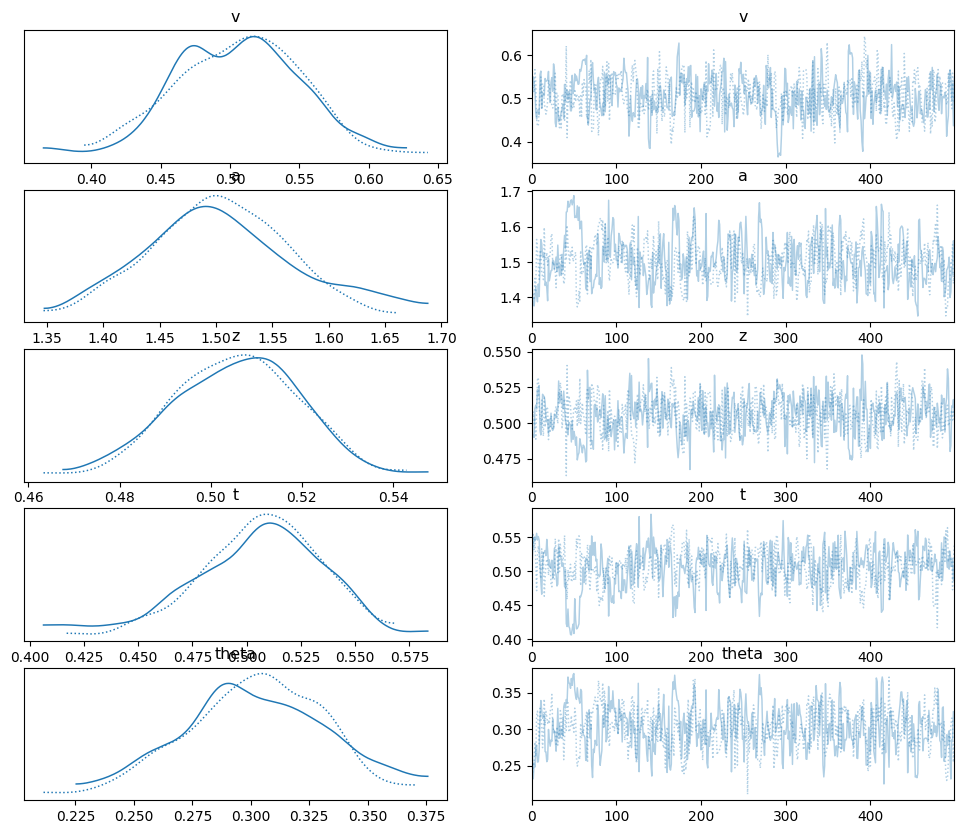

In [15]:
az.plot_trace(trace_angle_nuts)

### More General Example

In [16]:
# More general model-factory
# Makes use of model_config dictionary as part of the ssms package more
# extensively, so that we can generate models across named DDM variations
def make_pymc_model_new(model="angle", obs=None, torch_net=None, network_config=None):

    activation_dict = {"tanh": at.tanh}
    network_config_local = deepcopy(network_config)
    network_activations = network_config_local["activations"]

    with pm.Model() as pymc_model:
        variable_list = []
        for param_tmp in ssms.config.model_config[model]["params"]:
            param_id = ssms.config.model_config[model]["params"].index(param_tmp)
            ub = ssms.config.model_config[model]["param_bounds"][1][param_id]
            lb = ssms.config.model_config[model]["param_bounds"][0][param_id]
            variable_list.append(pm.Uniform(param_tmp, lb, ub))

        in_ = at.zeros(
            (len(obs_angle["rts"]), len(ssms.config.model_config[model]["params"]) + 2)
        )
        in_ = at.set_subtensor(in_[:, :-2], at.stack(variable_list))
        in_ = at.set_subtensor(in_[:, -2], obs["rts"][:, 0])
        in_ = at.set_subtensor(in_[:, -1], obs["choices"][:, 0])

        # Neural Net Part
        tmp = in_
        for i in range(0, len(torch_net.activations) - 1, 1):
            tmp = activation_dict[network_activations[i]](
                at.dot(tmp, torch_net.weights[i].numpy().astype(np.float32))
                + torch_net.biases[i].numpy().astype(np.float32)
            )
        tmp = at.dot(
            tmp, torch_net.weights[torch_net.net_depth - 1].numpy().astype(np.float32)
        ) + torch_net.biases[torch_net.net_depth - 1].numpy().astype(np.float32)

        pm.Potential("lan_llike", tmp)
    return pymc_model

### Load

In [17]:
m_angle = make_pymc_model_new(
    model="angle",
    obs=obs_angle,
    torch_net=custom_torch_net_angle,
    network_config=network_config,
)

NameError: name 'custom_torch_net_angle' is not defined

### Sample

In [ ]:
# sample with standard pymc
with m_angle:
    trace_angle_nuts = pm.sample(chains=2, draws=500, tune=500)

In [ ]:
az.summary(trace_angle_nuts)

In [ ]:
az.plot_trace(trace_angle_nuts)

In [ ]:
# sample with jax via numpyro
from pymc.sampling_jax import sample_numpyro_nuts

with m_angle:
    trace_angle_jax = sample_numpyro_nuts(chains=2, tune=500, draws=500)

In [ ]:
az.summary(trace_angle_jax)

In [ ]:
az.plot_trace(trace_angle_jax)

In [ ]:
x = trace_angle_jax.posterior.to_dataframe().reset_index(drop=True)

In [ ]:
import seaborn as sns

g = sns.PairGrid(x, corner=True)
g.map_lower(sns.kdeplot, fill=False, levels=5, bw_adjust=2)
# g.map_diag(sns.kdeplot,
#            bw_adjust = 2)
g.map_diag(sns.histplot, fill=False, element="step")

In [ ]:
x.corr()

### Hierarchical Part:

#### NOTE:

This doesn't work yet. It's just here as an example concerning where to go.

In [ ]:
def make_pymc_model_hierarchical(
    model="angle", obs=None, n_subjects=20, torch_net=None, network_config=None
):

    activation_dict = {"tanh": at.tanh}
    network_config_local = deepcopy(network_config)
    network_activations = network_config_local["activations"]

    with pm.Model() as pymc_model:
        variable_list = []
        for param_tmp in ssms.config.model_config[model]["params"]:
            param_id = ssms.config.model_config[model]["params"].index(param_tmp)
            ub = ssms.config.model_config[model]["param_bounds"][1][param_id]
            lb = ssms.config.model_config[model]["param_bounds"][0][param_id]
            variable_list.append(pm.Uniform(param_tmp, lb, ub))

        in_ = at.zeros((len(obs_angle["rts"]), 7))
        in_ = at.set_subtensor(in_[:, :-2], at.stack(variable_list))
        in_ = at.set_subtensor(in_[:, -2], obs["rts"][:, 0])
        in_ = at.set_subtensor(in_[:, -1], obs["choices"][:, 0])

        # Neural Net Part
        tmp = in_
        for i in range(0, len(torch_net.activations) - 1, 1):
            tmp = activation_dict[network_activations[i]](
                at.dot(tmp, torch_net.weights[i].numpy().astype(np.float32))
                + torch_net.biases[i].numpy().astype(np.float32)
            )
        tmp = at.dot(
            tmp, torch_net.weights[torch_net.net_depth - 1].numpy().astype(np.float32)
        ) + torch_net.biases[torch_net.net_depth - 1].numpy().astype(np.float32)

        pm.Potential("lan_llike", tmp)
    return pymc_model

In [ ]:
out = np.random.normal(loc=[0 for i in range(20)], scale=1, size=(100, 20)).astype(
    np.float32
)

In [ ]:
n_subjects = 200
n_data = 400
obs_tmp = np.random.normal(
    loc=[0 for i in range(n_subjects)], scale=1, size=(n_data, n_subjects)
).astype(np.float32)

coords = {"subjects": [str(i) for i in range(n_subjects)]}
with pm.Model(coords=coords) as test_model:
    group_mu_mu = pm.Normal("mu_mu", mu=0, sigma=10)
    group_mu_std = pm.HalfNormal("mu_std", sigma=100)
    group_std_std = pm.HalfNormal("std_std", sigma=100)

    subj_mu = pm.Normal("subj_mu", mu=group_mu_mu, sigma=group_mu_std, dims="subjects")

    obs = pm.Normal("obs", mu=subj_mu, sigma=group_std_std, observed=obs_tmp)

In [ ]:
model = "ddm"
model_config = ssms.config.model_config[model]

central_data_hierarchical = pickle.load(
    open(
        "data/hierarchical/"
        + model
        + "_nsamples_1000_nsubjects_20_nparams_200_stdfracdenom_6.pickle",
        "rb",
    )
)

dataset_idx = 0
data = central_data_hierarchical["data"][dataset_idx]["numpy"]
gt_params = central_data_hierarchical["data"][dataset_idx]["gt_params"]
n_samples = central_data_hierarchical["data"][dataset_idx]["numpyro"].shape[0]
n_subjects = central_data_hierarchical["data"][dataset_idx]["numpyro"].shape[1]

# network = load_network(model = model)

# print(ssms.config.model_config[model])

In [ ]:
obs_mu_mu = np.array([0.0, 0.5, 1.2, 0.5, 0.3])
obs_mu_std = np.array([0.1, 0.1, 0.1, 0.1, 0.1])

obs_params = np.random.normal(loc=obs_mu_mu, scale=obs_mu_std, size=(20, 5))

In [ ]:
obs_angle = ssms.basic_simulators.simulator(
    theta=obs_params, model="angle", n_samples=500
)

In [ ]:
obs = np.stack([obs_angle["rts"], obs_angle["choices"]], axis=2).squeeze()

In [ ]:
model_config = ssms.config.model_config["angle"]

In [ ]:
n_subjects = 20
n_data = 400
# obs_tmp = np.random.normal(loc = [0 for i in range(n_subjects)],
#                            scale = 1,
#                            size = (n_data, n_subjects)).astype(np.float32)


# make the data
obs_mu_mu = np.array([0.0, 0.5, 1.2, 0.5, 0.3])
obs_mu_std = np.array([0.1, 0.1, 0.1, 0.1, 0.1])

obs_params = np.random.normal(loc=obs_mu_mu, scale=obs_mu_std, size=(n_subjects, 5))
obs = ssms.basic_simulators.simulator(theta=obs_params, model="angle", n_samples=n_data)
obs = np.stack([obs["rts"], obs["choices"]], axis=2).squeeze()
# obs = np.swapaxes(obs, 0, 1)

coords = {
    "subjects": [str(i) for i in range(n_subjects)],
    "params": ["v", "a", "z", "t", "theta"],
}

param_means = []

for param in model_config["params"]:
    idx = model_config["params"].index(param)
    param_means.append(
        (model_config["param_bounds"][1][idx] + model_config["param_bounds"][0][idx])
        / 2
    )

param_means = np.array(param_means).astype(np.float32)
param_stds = np.array([100 for param in model_config["params"]]).astype(np.float32)

# Initialize custom pytorch network
# torch_net = CustomTorchMLP(torch_net.state_dict(), network_config)


with pm.Model(coords=coords) as test_model:
    #     def make_pymc_model_new(model = 'angle',
    #                         obs = None,
    #                         torch_net = None,
    #                         network_config = None):

    activation_dict = {"tanh": at.tanh}
    network_config_local = deepcopy(network_config)
    network_activations = network_config_local["activations"]

    group_mu_mu = pm.Normal("mu_mu", mu=param_means, sigma=0.5, dims="params")
    group_mu_std = pm.HalfNormal("mu_std", sigma=param_stds, dims="params")
    # group_std_std = pm.HalfNormal('std_std', sigma = 100)

    subj_param = pm.Normal(
        "subj_mu", mu=group_mu_mu, sigma=group_mu_std, dims=("subjects", "params")
    )

    in_ = at.zeros((obs.shape[0], obs.shape[1], 7))
    in_ = at.set_subtensor(in_[:, :, :-2], subj_param)  # at.stack(variable_list))
    in_ = at.set_subtensor(in_[:, :, -2], obs[:, :, 0])
    in_ = at.set_subtensor(in_[:, :, -1], obs[:, :, 0])

    # Neural Net Part
    tmp = in_
    for i in range(0, len(torch_net.activations) - 1, 1):
        tmp = activation_dict[network_activations[i]](
            at.dot(tmp, torch_net.weights[i].numpy().astype(np.float32))
            + torch_net.biases[i].numpy().astype(np.float32)
        )
    tmp = at.dot(
        tmp, torch_net.weights[torch_net.net_depth - 1].numpy().astype(np.float32)
    ) + torch_net.biases[torch_net.net_depth - 1].numpy().astype(np.float32)
    print(tmp.shape)
    pm.Potential("lan_llike", tmp)
    # obs = pm.Normal('obs', mu = subj_param, sigma = group_std_std, observed = obs_tmp)

In [ ]:
from pymc.sampling_jax import sample_numpyro_nuts

with test_model:
    trace_angle_jax = sample_numpyro_nuts(chains=2)

In [ ]:
az.summary(idata)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=309a84a8-4378-4e4a-ad40-54daa1f48cb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>